# Data Pre-Processing 

This notebook is for Data Processing where the downloaded Data is organized in matlab data format (.mat file). Each file stores a struct
containing the following fields for an image:
> **cjdata.label: 1 for meningioma, 2 for glioma, 3 for pituitary tumor**
> 
> **cjdata.PID: patient ID**
> 
> **cjdata.image: image data**
> 
> **cjdata.tumorBorder: a vector storing the coordinates of discrete points on tumor border.
		For example, [x1, y1, x2, y2,...] in which x1, y1 are planar coordinates on tumor border.
		It was generated by manually delineating the tumor border. So we can use it to generate
		binary image of tumor mask.**
		
> **cjdata.tumorMask: a binary image with 1s indicating tumor region**

In [69]:
import h5py
import csv

def load_mat_file(filename):
    with h5py.File(filename, 'r') as f:
        cjdata = f['cjdata']

        # Extract patient ID
        pid = cjdata['PID'][:]
        pid = ''.join(map(str, pid.flatten()))

        # Extract label
        labels = np.array(cjdata['label'])
        label = labels[0][0]  # Assuming labels is a 2D array with shape (1, 1) or similar

        # Convert label to integer for CSV
        label = int(label)

        # Load image data
        image_data = np.array(cjdata['image'])

        # Check if image data needs reshaping
        if len(image_data.shape) == 1:
            image_data = image_data.reshape((int(np.sqrt(len(image_data))), int(np.sqrt(len(image_data)))))
        elif len(image_data.shape) == 3:
            if image_data.shape[0] == 1:
                image_data = image_data[0]

        # Load tumor mask data
        tumor_masks = np.array(cjdata['tumorMask'])

        # Determine the directory based on the label
        if label == 1:
            dir = "/home/ahmed/PycharmProjects/Covid/Organized/1"
        elif label == 2:
            dir = "/home/ahmed/PycharmProjects/Covid/Organized/2"
        elif label == 3:
            dir = "/home/ahmed/PycharmProjects/Covid/Organized/3"
        else:
            print(f"Unknown label {label}. Skipping file.")
            return None, None, None, None

        # Create directory if it doesn't exist
        os.makedirs(dir, exist_ok=True)

        # Normalize and save image data
        image_data = cv2.normalize(image_data, None, 0, 255, cv2.NORM_MINMAX)
        image_data = image_data.astype(np.uint8)
        image_data = cv2.cvtColor(image_data, cv2.COLOR_GRAY2BGR)
        base_filename = os.path.splitext(os.path.basename(filename))[0]
        image_path = os.path.join(dir, f'{pid}_{base_filename}_image.png')
        cv2.imwrite(image_path, image_data)

        # Normalize and save tumor masks
        tumor_masks = cv2.normalize(tumor_masks, None, 0, 255, cv2.NORM_MINMAX)
        tumor_masks = np.uint8(tumor_masks)
        mask_path = os.path.join(dir, f'{pid}_{base_filename}_mask.png')
        cv2.imwrite(mask_path, tumor_masks)

    return pid, label, image_path, mask_path

def process_all_mat_files(root_directory):
    patient_data = []
    for dirpath, dirnames, filenames in os.walk(root_directory):
        for filename in filenames:
            if filename.endswith('.mat'):
                file_path = os.path.join(dirpath, filename)
                pid, label, image_path, mask_path = load_mat_file(file_path)
                if pid and label and image_path and mask_path:
                    patient_data.append((pid, label, image_path, mask_path))

    return patient_data

def write_csv(patient_data, output_csv):
    with open(output_csv, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['Patient_ID', 'Label', 'Image_Path', 'Mask_Path'])
        for pid, label, image_path, mask_path in patient_data:
            csvwriter.writerow([pid, label, image_path, mask_path])

# directory containing .mat files and subdirectories
directory_path = '/home/ahmed/PycharmProjects/Covid/Data'
output_csv = '/home/ahmed/PycharmProjects/Covid/Organized/patients_labels.csv'

# Process all .mat files in the directory and subdirectories, and collect patient data
patient_data = process_all_mat_files(directory_path)

# save the patient data to csv file 
write_csv(patient_data, output_csv)

print(f"CSV file '{output_csv}' successfully created.")


CSV file '/home/ahmed/PycharmProjects/Covid/Organized/patients_labels.csv' successfully created.



This code extracts data from **.mat** files, generating images and masks. It also creates a CSV file containing patient IDs, labels, and the paths to the corresponding images and masks. Additionally, the code organizes the images into three separate folders, one for each class.

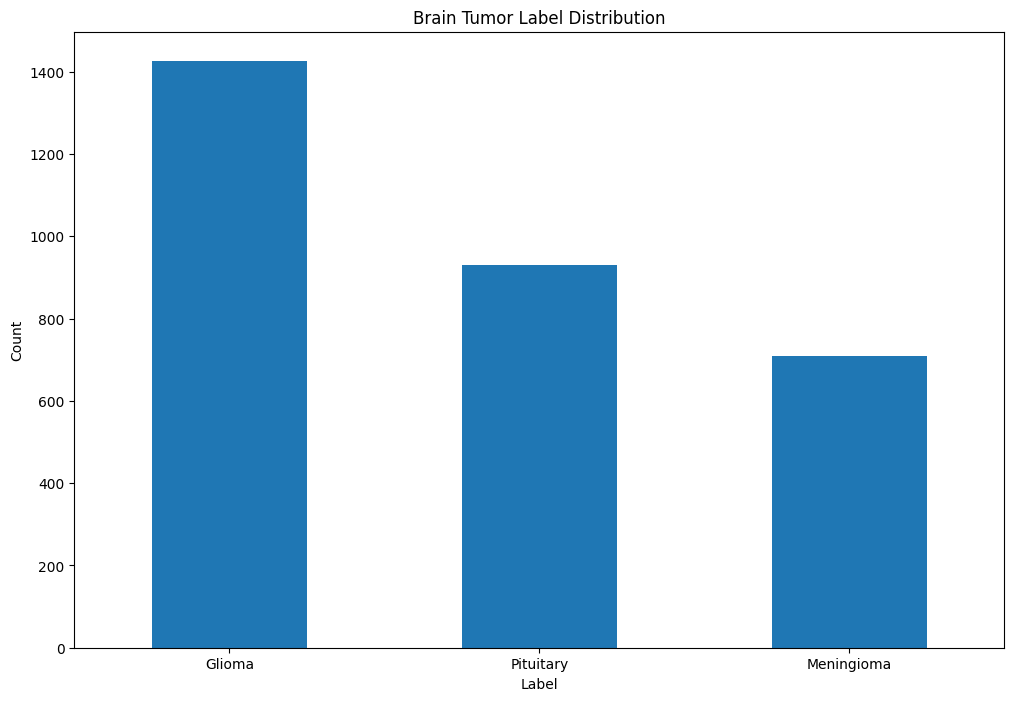

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('/home/ahmed/PycharmProjects/Covid/Organized/patients_labels.csv')

# Create the plot for label distribution
plt.figure(figsize=(12, 8))  
ax = data["Label"].value_counts().plot(kind='bar')

# Change the Label name to be more understandable 
new_labels = ['Glioma', 'Pituitary', 'Meningioma']  
ax.set_xticklabels(new_labels, rotation=0)

plt.title('Brain Tumor Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

# Show the plot
plt.show()



In [166]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your data from CSV
data = pd.read_csv('/home/ahmed/PycharmProjects/Covid/Organized/patients_labels.csv')

# Get unique patients and create a mapping from Patient_ID to Label
patient_labels = data.groupby('Patient_ID')['Label'].apply(lambda x: x.mode()[0])

# First, split patients into training (50%) and test+validation (50%)
train_val_patients, test_patients = train_test_split(
    patient_labels.index, 
    test_size=0.50, 
    random_state=42,  # For reproducibility
    stratify=patient_labels
)

# Then, split test+validation patients into validation (25%) and testing (25%)
val_patients, test_patients = train_test_split(
    test_patients, 
    test_size=0.50,  # 50% of the remaining 50% -> 25% of original data
    random_state=42,  # For reproducibility
    stratify=patient_labels[test_patients]
)

# Create training, validation, and testing datasets based on patient splits
train_df = data[data['Patient_ID'].isin(train_val_patients)]
valid_df = data[data['Patient_ID'].isin(val_patients)]
test_df = data[data['Patient_ID'].isin(test_patients)]

# Check the label distributions to verify stratification
print("Training set label distribution:")
print(train_df['Label'].value_counts(normalize=True))
print("\nValidation set label distribution:")
print(valid_df['Label'].value_counts(normalize=True))
print("\nTesting set label distribution:")
print(test_df['Label'].value_counts(normalize=True))

# Optionally save these datasets to CSV files
train_df.to_csv('/home/ahmed/PycharmProjects/Covid/Organized/train.csv', index=False)
valid_df.to_csv('/home/ahmed/PycharmProjects/Covid/Organized/valid.csv', index=False)
test_df.to_csv('/home/ahmed/PycharmProjects/Covid/Organized/test.csv', index=False)


Training set label distribution:
Label
2    0.467354
3    0.299656
1    0.232990
Name: proportion, dtype: float64

Validation set label distribution:
Label
2    0.451138
3    0.337349
1    0.211513
Name: proportion, dtype: float64

Testing set label distribution:
Label
2    0.474478
3    0.280742
1    0.244780
Name: proportion, dtype: float64


The data was partitioned by patient, which is an important step to ensure data integrity and to prevent **data leakage**. This method ensure that information from the same patient does not appear in both the training and validation sets, therefore maintaining the validity and reliability of the analysis.

We use stratification to ensure that the class distribution is preserved in each split. which is an important in medical data. Stratification helps to ensure that each split has a representative distribution of classes, leading to more reliable training and evaluation.


In [167]:
# Converts Patient ID to list 
A = train_df["Patient_ID"].tolist()
B = valid_df["Patient_ID"].tolist()
C = test_df["Patient_ID"].tolist()

# Convert the list to set to remove duplicates 
A = set(A)
B = set(B)
C = set(C)

# Final the intersection between the sets 
Final = set.intersection(A,B)
print(Final)

Final = set.intersection(A,C)
print(Final)

Final = set.intersection(B,C)
print(Final)

Final = set.intersection(A,B,C)
print(Final)

set()
set()
set()
set()


This code ensures that there is no overlap of patient data between the training, validation, and testing sets.This approach is critical to make sure there is no data leakage and get result the represent the reality 


In [168]:
import shutil

def data_split(df_path,dst_dir_mask,dst_dir_image):
    
    # Ensure the destinations directory exists
    os.makedirs(dst_dir_mask, exist_ok=True)
    os.makedirs(dst_dir_image, exist_ok=True)
    
    # load the CSV file
    df = pd.read_csv(df_path)
    
    
    for row in df.iterrows():
        # Extract image name, label, image path, and mask path from the row
        image_name, label, image_path, mask_path = row[1]
        # Create label-specific directories for both images and masks
        image_label_dir = os.path.join(dst_dir_image, str(label))
        mask_label_dir = os.path.join(dst_dir_mask, str(label))
        os.makedirs(image_label_dir, exist_ok=True)
        os.makedirs(mask_label_dir, exist_ok=True)
        # Copy image to the appropriate label-specific directory
        filename = os.path.basename(image_path)
        dst_image_path = os.path.join(image_label_dir, filename)
        shutil.copy2(image_path, dst_image_path)
        print(f"Copied {image_path} to {dst_image_path}")
        # Copy mask to the appropriate label-specific directory
        filename = os.path.basename(mask_path)
        dst_mask_path = os.path.join(mask_label_dir, filename)
        shutil.copy2(mask_path, dst_mask_path)
        print(f"Copied {mask_path} to {dst_mask_path}")
    
    print("Process Complete")

In [169]:
data_split(df_path="/home/ahmed/PycharmProjects/Covid/Organized/train.csv",
           dst_dir_mask="/home/ahmed/PycharmProjects/Covid/Organized/Final_dataset/Mask/Train",
          dst_dir_image="/home/ahmed/PycharmProjects/Covid/Organized/Final_dataset/images/Train")

data_split(df_path="/home/ahmed/PycharmProjects/Covid/Organized/valid.csv",
           dst_dir_mask="/home/ahmed/PycharmProjects/Covid/Organized/Final_dataset/Mask/Valid",
           dst_dir_image="/home/ahmed/PycharmProjects/Covid/Organized/Final_dataset/images/Valid")

data_split(df_path="/home/ahmed/PycharmProjects/Covid/Organized/test.csv",
          dst_dir_mask="/home/ahmed/PycharmProjects/Covid/Organized/Final_dataset/Mask/Test",
          dst_dir_image="/home/ahmed/PycharmProjects/Covid/Organized/Final_dataset/images/Test")


Copied /home/ahmed/PycharmProjects/Covid/Organized/3/494857555457_962_image.png to /home/ahmed/PycharmProjects/Covid/Organized/Final_dataset/images/Train/3/494857555457_962_image.png
Copied /home/ahmed/PycharmProjects/Covid/Organized/3/494857555457_962_mask.png to /home/ahmed/PycharmProjects/Covid/Organized/Final_dataset/Mask/Train/3/494857555457_962_mask.png
Copied /home/ahmed/PycharmProjects/Covid/Organized/3/494949555653_990_image.png to /home/ahmed/PycharmProjects/Covid/Organized/Final_dataset/images/Train/3/494949555653_990_image.png
Copied /home/ahmed/PycharmProjects/Covid/Organized/3/494949555653_990_mask.png to /home/ahmed/PycharmProjects/Covid/Organized/Final_dataset/Mask/Train/3/494949555653_990_mask.png
Copied /home/ahmed/PycharmProjects/Covid/Organized/3/494851545548_1324_image.png to /home/ahmed/PycharmProjects/Covid/Organized/Final_dataset/images/Train/3/494851545548_1324_image.png
Copied /home/ahmed/PycharmProjects/Covid/Organized/3/494851545548_1324_mask.png to /home/ah

The above steps separate the images and masks into distinct folders, organized into Train, Validation, and Test sets:


# Data Analysis 

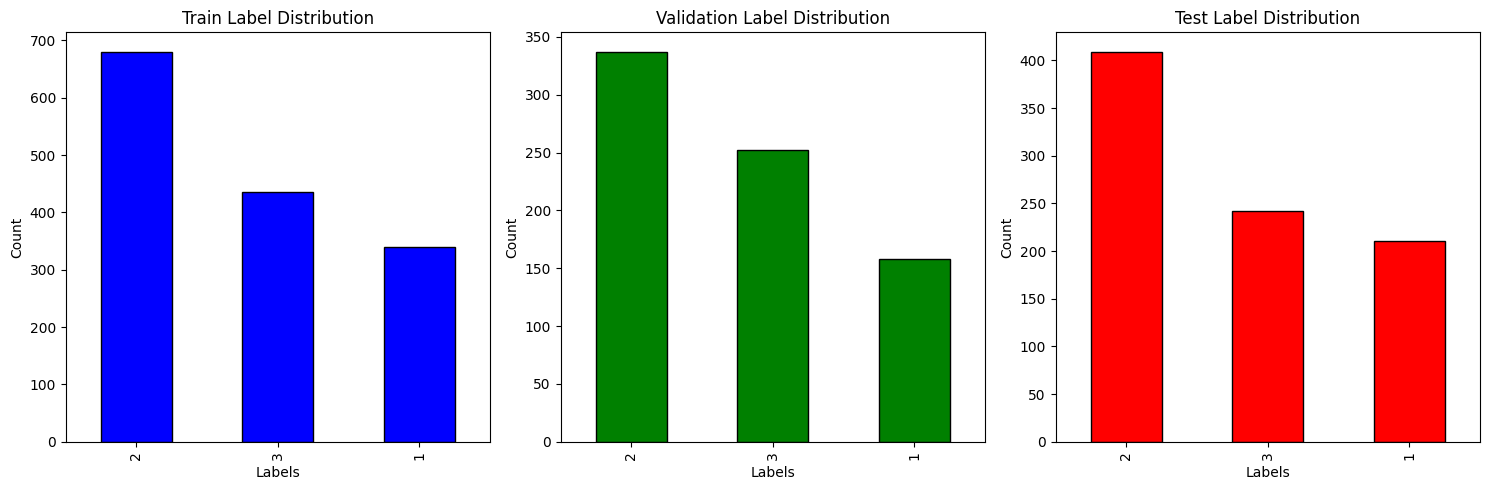

In [197]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 5))

# Training Data Distribution
plt.subplot(1, 3, 1)
train_df["Label"].value_counts().plot(kind='bar', color='blue', edgecolor='black')
plt.title('Train Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')

# Validation Data Distribution
plt.subplot(1, 3, 2)
valid_df["Label"].value_counts().plot(kind='bar', color='green', edgecolor='black')
plt.title('Validation Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')

# Testing Data Distribution
plt.subplot(1, 3, 3)
test_df["Label"].value_counts().plot(kind='bar', color='red', edgecolor='black')
plt.title('Test Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')


plt.tight_layout()


plt.show()


**The Three classes have the same distribution** 
1. All three sets show class imbalance where Class 2 being the majority and Class 1 the minority
2. The validation and test sets have been stratified to maintain the original data distribution
3. The training set will undergo augmentation to balance classes and prevent bias
4. Evaluation metrics should account for this class imbalance, especially in validation and testing


In [174]:
train_df["Label"].value_counts()

Label
2    680
3    436
1    339
Name: count, dtype: int64

In [172]:
valid_df["Label"].value_counts()

Label
2    337
3    252
1    158
Name: count, dtype: int64

In [173]:
test_df["Label"].value_counts()

Label
2    409
3    242
1    211
Name: count, dtype: int64

# Data Augmentation

The augmentation techniques, such as rotation, flipping, adding noise, blurring, and adjusting brightness and contrast, are defined using the Albumentations library. These transformations help to create a more robust training dataset by simulating different real-world variations and distortions that the model might encounter, ultimately improving its generalization capabilities.

**Note** : Data Augmentation is only done to the training data. Not Validation or Testing


In [198]:
import os
import cv2
import numpy as np
from PIL import Image
import albumentations as A

# Input and Output Dir
input_dir = '/home/ahmed/PycharmProjects/Covid/Organized/Final_dataset/images/Train'
output_dir = '/home/ahmed/PycharmProjects/Covid/Organized/Final_dataset/images/Aug/'


os.makedirs(output_dir, exist_ok=True)

# Define augmentations per class "Since some class have high number of images "
class_augmentations = {
    '1': 4,
    '2': 1,
    '3': 3
}

# Define the augmentation pipeline
transform = A.Compose([
    A.RandomRotate90(p=0.5),
    A.Flip(p=0.5),
    A.Transpose(p=0.5),
    A.OneOf([
        A.GaussNoise(p=0.2),
        A.MultiplicativeNoise(p=0.2),
    ], p=0.2),
    A.OneOf([
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
    A.OneOf([
        A.OpticalDistortion(p=0.3),
        A.GridDistortion(p=0.1),
        A.ElasticTransform(p=0.3),
    ], p=0.2),
    A.OneOf([
        A.CLAHE(clip_limit=2),
        A.Sharpen(),
        A.Emboss(),
        A.RandomBrightnessContrast(),
    ], p=0.3),
    A.HueSaturationValue(p=0.3),
])



def load_image(image_path):
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

def save_image(image, save_path):
    Image.fromarray(image).save(save_path)


# Iterate through classes (subdirectories) in the input directory
for class_name in os.listdir(input_dir):
    class_dir = os.path.join(input_dir, class_name)
    if not os.path.isdir(class_dir):
        continue

    # Create output subdirectory for this class
    class_output_dir = os.path.join(output_dir, class_name)
    os.makedirs(class_output_dir, exist_ok=True)

    # Get number of augmentations for this class
    num_augmentations = class_augmentations.get(class_name, 1)  # Default to 1 if class not specified

    # Iterate through images in the class subdirectory
    for filename in os.listdir(class_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
            # Load image
            image_path = os.path.join(class_dir, filename)
            image = load_image(image_path)

            # Save original image
            save_image(image, os.path.join(class_output_dir, filename))

            # Create augmented versions
            for i in range(num_augmentations):
                # Apply augmentation
                augmented = transform(image=image)['image']

                # Save augmented image
                base_filename, ext = os.path.splitext(filename)
                save_path = os.path.join(class_output_dir, f'{base_filename}_aug_{i + 1}{ext}')
                save_image(augmented, save_path)

print("Augmentation complete!")

Augmentation complete!


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


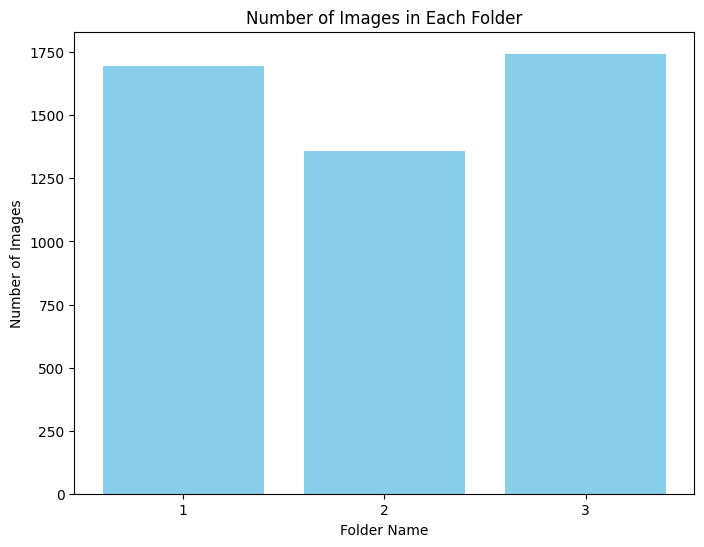

In [199]:
import os
import matplotlib.pyplot as plt

# Define the folder paths
folder_paths = ['/home/ahmed/PycharmProjects/Covid/Organized/Final_dataset/images/Aug/1', '/home/ahmed/PycharmProjects/Covid/Organized/Final_dataset/images/Aug/2',
                '/home/ahmed/PycharmProjects/Covid/Organized/Final_dataset/images/Aug/3']

# Initialize lists for folder names and image counts
folders = []
image_counts = []

# Define a set of image extensions
image_extensions = {'.png', '.jpg'}

# Count the number of images in each folder
for folder in folder_paths:
    count = sum(1 for file in os.listdir(folder) if os.path.splitext(file)[1].lower() in image_extensions)
    folders.append(os.path.basename(folder))  
    image_counts.append(count)

# Create bar plot
plt.figure(figsize=(8, 6))
plt.bar(folders, image_counts, color='skyblue')

# Add labels and title
plt.xlabel('Folder Name')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Folder')

# Show plot
plt.show()


After Data Augmentation, The Data become more balance 

In [200]:
Train_ratio = np.sum(image_counts)/(np.sum(image_counts)+valid_df.shape[0]+test_df.shape[0])
valid_ratio = valid_df.shape[0]/(np.sum(image_counts)+valid_df.shape[0]+test_df.shape[0])
test_ratio = test_df.shape[0]/(np.sum(image_counts)+valid_df.shape[0]+test_df.shape[0])

print("Train Ratio: ", Train_ratio, "Valid Ratio: ", valid_ratio, "Test Ratio: ", test_ratio)

Train Ratio:  0.7489076154806492 Valid Ratio:  0.11657303370786516 Test Ratio:  0.13451935081148564


Training is almost 80% and both validation and testing is almost 20%